## Intro bayesian modelling using pymc!

Author: Johan Thor with code proudly stolen from Simon Hedström



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("sodra.mplstyle")

import pymc as pm
import arviz as az


In [103]:
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)


In [104]:
# Below functions are written by Simon:


def delinearize(x):
    """Performs a linear regression and subtracts it from the signal."""
    k, m = np.polyfit(np.arange(len(x)), x, 1)
    return x - (k * np.arange(len(x)) + m)


def standardize(x):
    """Standardizes the signal using the sample mean and standard deviation."""
    std = np.std(x)
    if std == 0:
        std = 1
    return (x - np.mean(x)) / std


# Creating our initial problem

We generate the following signals $s_i$:
1. Random walk. Exponentially smoothed with a factor of $\frac{1}{30}$. Delinearized. Standardized. 
2. Sine wave with boolean logic $sin(t) > 0$. Standardized.
    
    
We construct our prediction target $y = standardize(s_1 + s_2)$.   
On top of that we also distort out target by adding noise $v \sim exp(\frac{1}{4})$

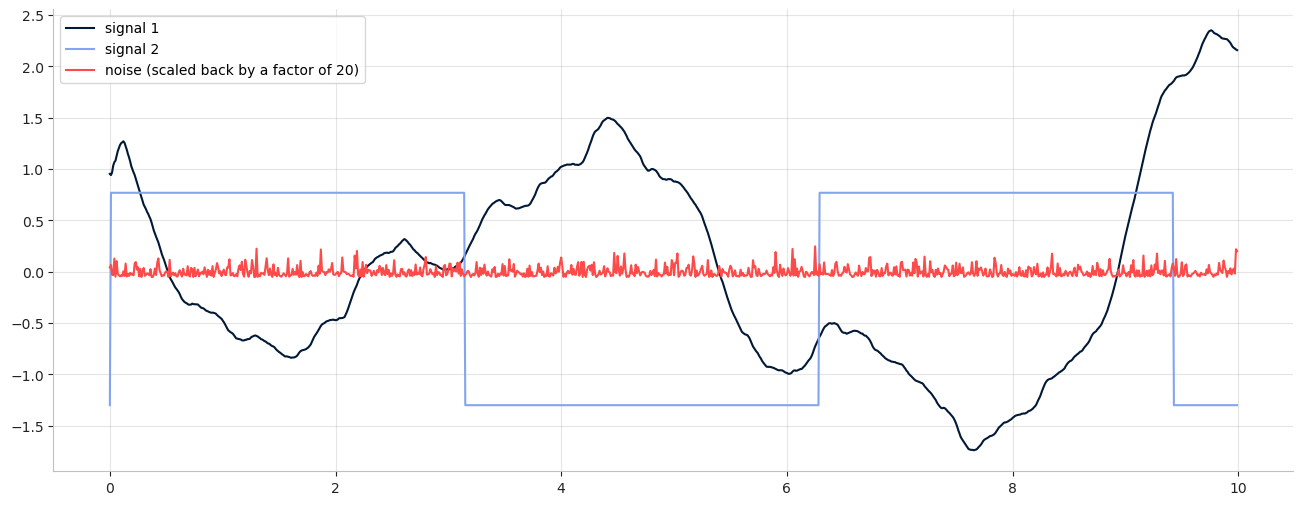

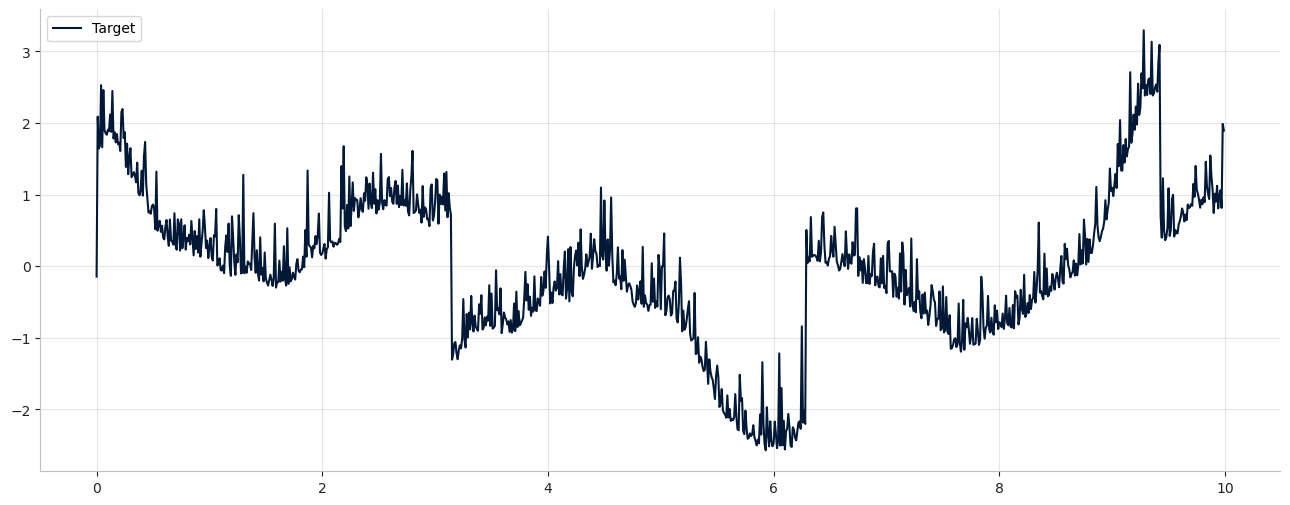

In [110]:
np.random.seed(RANDOM_SEED)


N = 1000
dt = 0.01
noise_factor = 1 / 4

# Time
t = dt * np.arange(N)

# Signal 1
signal1 = np.cumsum(np.random.randn(N))
signal1 = pd.Series(signal1).ewm(alpha=1 / 30).mean().values
signal1 = standardize(delinearize(signal1))

# Signal 2
signal2 = standardize(np.sin(t) > 0)

# Target
target = standardize(signal1 + signal2)

# Noise to target
noise = standardize(-np.log(np.random.rand(N)) - 1)
target += noise * noise_factor

# Plot data
fig, ax = plt.subplots()
ax.plot(t, signal1, label="signal 1")
ax.plot(t, signal2, label="signal 2")
ax.plot(t, noise / 20, label="noise (scaled back by a factor of 20)")
ax.legend()
plt.show()

# Plot target
fig, ax = plt.subplots()
ax.plot(t, target, label="Target")
ax.legend()
plt.show()


In [4]:
# Create X and Y
x = np.vstack([signal1, signal2]).T
y = target.reshape(-1, 1)

n_train = N // 3

# Get training set
t_train = t[:n_train]
x_train = x[:n_train]
y_train = y[:n_train]

# Get remaining set, predict
t_rest = t[n_train:]
x_rest = x[n_train:]
y_rest = y[n_train:]


In [5]:
# Let's make a model in pymc!

# 1. Start with the priors:
a_normal_distribution = pm.Normal.dist(mu=0, sigma=5)
a_half_normal_distribution = pm.HalfNormal.dist(sigma=5)
    

In [90]:
with pm.Model() as linear_model:

    beta = pm.Normal("beta", mu=0, sigma=5, shape=3)
    sigma = pm.HalfNormal("sigma", sigma=5)

    my = beta[0] + beta[1] * x_train + beta[2] * np.sin(x_train) # + beta[3]*x_train

    ppl_target = pm.Normal("target", mu=my, sigma=sigma, observed=y_train)


In [91]:
with linear_model:
    linear_trace = pm.sample(1000, tune=2000, cores=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, sigma]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 34 seconds.


array([[<AxesSubplot: title={'center': 'beta'}>,
        <AxesSubplot: title={'center': 'beta'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

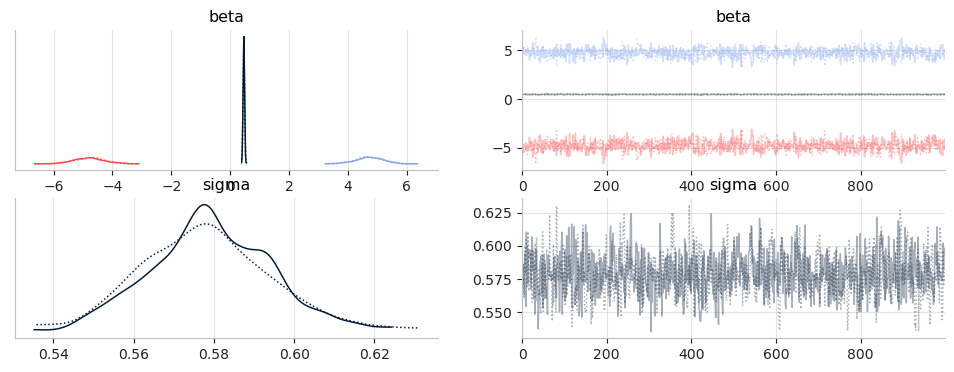

In [92]:
az.plot_trace(linear_trace)

In [94]:
az.summary(linear_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.46,0.02,0.42,0.51,0.00,0.00,1170.98,996.06,1.0
beta[1],4.72,0.46,3.79,5.53,0.02,0.01,762.48,947.74,1.0
beta[2],-4.78,0.52,-5.74,-3.77,0.02,0.01,760.49,920.79,1.0
sigma,0.58,0.02,0.55,0.61,0.00,0.00,897.56,838.14,1.0


In [95]:
X_pred = np.linspace(0, 10, 1000)

In [96]:
# chain, sample, [beta_0/beta_1]:
linear_trace.posterior.beta.shape


(2, 1000, 3)

In [97]:
linear_trace.posterior.sigma.shape

(2, 1000)

In [98]:
beta_0 = linear_trace.posterior.beta[1, :, 0]
beta_1 = linear_trace.posterior.beta[1, :, 1]
beta_2 = linear_trace.posterior.beta[1, :, 2]

sigma = linear_trace.posterior.sigma[1, :]


In [99]:
print(beta_0, beta_1, sigma)

<xarray.DataArray 'beta' (draw: 1000)>
array([0.4662646 , 0.4362882 , 0.42592869, 0.45774916, 0.48010482,
       0.44048798, 0.50460111, 0.45722767, 0.46868438, 0.46240682,
       0.48915136, 0.50763399, 0.52478107, 0.50912261, 0.46805049,
       0.48092414, 0.47117508, 0.47887782, 0.48190408, 0.43318649,
       0.4928986 , 0.44854338, 0.48257119, 0.42328   , 0.43358674,
       0.49343639, 0.46615843, 0.47587747, 0.46909125, 0.5051948 ,
       0.5183202 , 0.46627528, 0.47714206, 0.45641669, 0.49789192,
       0.43833622, 0.50446708, 0.46415588, 0.41833286, 0.41800929,
       0.49625541, 0.48793937, 0.4316398 , 0.47963718, 0.45932946,
       0.45913402, 0.47803316, 0.44347398, 0.48102243, 0.49041192,
       0.44870718, 0.44649161, 0.46960914, 0.45507746, 0.49097281,
       0.43836033, 0.45270092, 0.4590344 , 0.45113837, 0.47347323,
       0.4723452 , 0.48961866, 0.46485008, 0.49270643, 0.49705304,
       0.46812514, 0.46199064, 0.47226422, 0.44303632, 0.48604599,
       0.48761538, 0.43

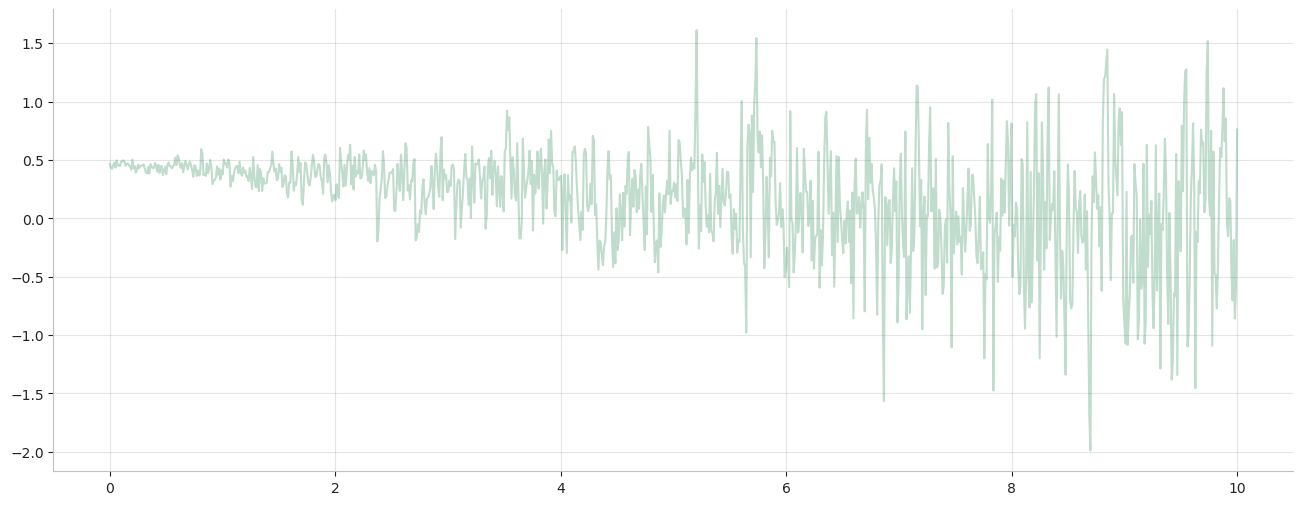

In [100]:
X_pred = np.linspace(0, 10, 1000)

# ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
# ax.set_ylim(0, None)
# for b0 in linear_trace.posterior["beta"][:2]:
plt.plot(X_pred, beta_0 + beta_1 * X_pred + beta_2*X_pred, alpha=0.3, color="seagreen")
